## Importing required functions

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Scrapping data from target website:

In [ ]:

data = requests.get('https://www.iiserkol.ac.in/web/en/people/faculty/dbs/')
soup = BeautifulSoup(data.content, "html.parser")

# Collecting faculty profile URLs
urls = [link['href'] for link in soup.find_all('a')]
urls = [url for url in urls if '/web/en/people/faculty/dbs/' in url]
link = 'https://www.iiserkol.ac.in'
faculty_websites = list(set([link + url for url in urls]))

all_data = []

for faculty_url in faculty_websites:
    data = requests.get(faculty_url)
    soup = BeautifulSoup(data.content, "html.parser")

    name = soup.find_all('h3')
    faculty_name = [name.text for name in name]
    faculty_name = faculty_name[3] if faculty_name else ''

    content = soup.find_all('div', class_='col-md-12 innerdiv')
    profile_data = {
        "Name": faculty_name,
        "Research Interest": None,
        "Academic Background": None,
        "PhD": None,
        "PhD Year": None,
        "Positions": None,
        "Awards and Honors": None,
        "Number of awards": None,
    }

    for section in content:
        section_text = section.text

        if 'Research Interest:' in section_text:
            profile_data["Research Interest"] = re.sub(r'Research Interest:\s+', '', section_text)

        elif 'Academic Background:' in section_text:
            profile_data["Academic Background"] = re.sub(r'Academic Background:\s+', '', section_text)
            c = re.search(r"\d", section_text)
            if c:
                x = c.start()
                profile_data["PhD Year"] = section_text[x:x+4]
            if 'PhD' in section_text or 'phd' in section_text or 'Ph.D' in section_text or 'Ph.D.' in section_text:
                profile_data["PhD"] = section_text[21:x-1]

        elif 'Positions:' in section_text:
            profile_data["Positions"] = re.sub(r'Positions:\s+', '', section_text)

        elif 'Awards and Honors:' in section_text:
            profile_data["Awards and Honors"] = re.sub(r'Awards and Honors:\s+', '', section_text)
            profile_data["Number of awards"] = section_text.count('20') + section_text.count('19')

    all_data.append(profile_data)



## Creating a Database:

In [ ]:
conn = sqlite3.connect("faculty_data.db")
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS Faculty")

cursor.execute('''
    CREATE TABLE Faculty (
        Name TEXT,
        Research_Interest TEXT,
        Academic_Background TEXT,
        PhD TEXT,
        PhD_Year INTEGER,
        Positions TEXT,
        Awards_and_Honors TEXT,
        Number_of_awards INTEGER
    )
''')

for profile in all_data:
    cursor.execute('''
        INSERT INTO Faculty (
            Name, Research_Interest, Academic_Background, PhD, PhD_Year,
            Positions, Awards_and_Honors, Number_of_awards
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        profile["Name"],
        profile["Research Interest"],
        profile["Academic Background"],
        profile["PhD"],
        profile["PhD Year"],
        profile["Positions"],
        profile["Awards and Honors"],
        profile["Number of awards"]
    ))

conn.commit()

df = pd.read_sql_query("SELECT * FROM Faculty", conn)

conn.close()

In [51]:
df

,Name,Research_Interest,Academic_Background,PhD,PhD_Year,Positions,Awards_and_Honors,Number_of_awards
0,Sankar Maiti,Regulation of Actin Cytoskeleton,"PhD (Biology), IMTECH, Chandigarh (Punjab Univ...","PhD (Biology), IMTECH, Chandigarh (Punjab Univ...",2003.0,"Associate Professor, IISER Kolkata ( - )Postdo...",None,NaN
1,Supratim Datta,The research in my laboratory focuses on engin...,"Ph.D. (Chemistry), Boston University, Boston, ...","Ph.D. (Chemistry), Boston University, Boston,",2005.0,"Professor, IISER Kolkata (current) Asso...",Ramanujan Fellowship from Government of India ...,2.0
2,Bidisha Sinha,The theme of the lab is to understand how cell...,"PhD (Life Sciences), National Centre for Biolo...","PhD (Life Sciences), National Centre for Biolo...",2007.0,"Associate Professor, IISER Kolkata (curre...",Intermediate Fellowship from Wellcome Trust DB...,2.0
3,Jayasri Das Sarma,My laboratory is involved in the study of neur...,"PhD (Immunology/Biochemistry), Indian Statisti...","PhD (Immunology/Biochemistry), Indian Statisti...",1995.0,"Professor, IISER Kolkata ( - )Adjunct Associat...",ASMCUE Leadership Award for International Educ...,7.0
4,Sreeramaiah Gangappa,"The ability to perceive, integrate, and proces...","PhD (Plant Molecular Biology), NIPGR (JNU, New...","PhD (Plant Molecular Biology), NIPGR (JNU, New...",2009.0,"Assistant Professor, IISER Kolkata ( - )Marie-...",Ramalingaswami Re-entry Felloship from Departm...,2.0
5,Robert John Chandran,We conduct ecological research at the populati...,"PhD (Tropical Forest Ecology), Centre for Ecol...","PhD (Tropical Forest Ecology), Centre for Ecol...",2001.0,"Associate Professor, IISER Kolkata (curre...",None,NaN
6,Amit Kumar Mandal,Molecular Medicine - Structural Biology of pro...,"PhD (Biophysical Chemistry), Bose Institute (J...","PhD (Biophysical Chemistry), Bose Institute (J...",2004.0,"Associate Professor, IISER Kolkata (curre...",Centers of Innovation (COI) [www.waters.com/wa...,1.0
7,Partha Pratim Datta,We are trying to understand the action mechani...,"PhD (Molecular Biology), IICB (Jadavpur Univer...","PhD (Molecular Biology), IICB (Jadavpur Univer...",2002.0,"Associate Professor, IISER Kolkata (curre...",Robert J. Colinas Award for Outstanding Postdo...,2.0
8,Rupak Datta,Lysosomes are cell's recycling and waste dispo...,"PhD (Biochemistry & Molecular Biology), Indian...","PhD (Biochemistry & Molecular Biology), Indian...",2006.0,"Professor, IISER Kolkata (current) Asso...",Young Investigator Award from International Co...,4.0
9,Amirul Islam Mallick,My research focuses on studying host-pathogen ...,"PhD (Biotechnology), Interdisciplinary Biotech...","PhD (Biotechnology), Interdisciplinary Biotech...",2008.0,"Associate Professor, IISER Kolkata (curre...",Scientific High Level Visiting Fellowships (SS...,12.0


# Data Analysis

#### Location of PhD:
Sample Data Obtained for Places in India

In [11]:
Indian_cities= ["India", "Indian", "National", "national" "Andhra Pradesh", "Arunachal Pradesh", "Assam", "Bihar", 
                    "Chhattisgarh", "Goa", "Gujarat", "Haryana", "Himachal Pradesh", 
                    "Jharkhand", "Karnataka", "Kerala", "Madhya Pradesh", "Maharashtra", "Manipal"
                    "Manipur", "Meghalaya", "Mizoram", "Nagaland", "Odisha", "Punjab", "Ropar"
                    "Rajasthan", "Sikkim", "Tamil Nadu", "Telangana", "Tripura", "Uttar Pradesh", "Kharagpur"
                    "Uttarakhand", "West Bengal", "Andaman and Nicobar Islands", "Chandigarh", "Bombay", "Madras"
                    "Dadra and Nagar Haveli and Daman and Diu", "Lakshadweep", "Delhi", "Puducherry","Dharwad"
                    "Ladakh", "Jammu and Kashmir""New Delhi", "Mumbai", "Bengaluru", "Hyderabad", "Chennai", 
                    "Kolkata", "Ahmedabad", "Pune", "Jaipur", "Surat", "Lucknow", "Kanpur", "Nagpur", "Visakhapatnam",
                    "Bhopal", "Patna", "Vadodara", "Ghaziabad", "Ludhiana", "Agra", "Nashik", "Faridabad", "Meerut", 
                    "Rajkot", "Kalyan-Dombivli", "Vasai-Virar", "Varanasi", "Srinagar", "Aurangabad", "Dhanbad",
                    "Amritsar", "Navi Mumbai", "Allahabad", "Howrah", "Ranchi", "Gwalior", "Jabalpur", "Coimbatore",
                    "Vijayawada", "Jodhpur", "Madurai", "Raipur", "Kota", "Guwahati", "Chandigarh", "Solapur", 
                    "Hubli-Dharwad", "Bareilly", "Mysuru", "Tiruchirappalli", "Tiruppur", "Salem", "Aligarh", "Calcutta"
                    "Thiruvananthapuram", "Bhiwandi", "Saharanpur", "Gorakhpur", "Guntur", "Bikaner", "Amravati", 
                    "Noida", "Jamshedpur", "Bhilai", "Cuttack", "Firozabad", "Kochi", "Bhavnagar", "Dehradun", 
                    "Durgapur", "Asansol", "Nanded", "Kolhapur", "JNU", "Ajmer", "Akola", "Gulbarga", "Jamnagar", "Ujjain",
                    "Loni", "Siliguri", "Jhansi", "Ulhasnagar", "Sangli", "Belgaum", "Mangalore", "Ambattur", 
                    "Tirunelveli", "Malegaon", "Gaya", "Jalgaon", "Udaipur", "Maheshtala", "Davanagere", "Kozhikode", 
                    "Kurnool", "Rajahmundry", "Bokaro", "South Dumdum", "Bellary", "Patiala", "Agartala", "Bhagalpur", 
                    "Muzaffarnagar", "Bhatpara", "Panihati", "Latur", "Dhule", "Rohtak", "Korba", "Bhilwara", "Brahmapur", 
                    "Muzaffarpur", "Ahmednagar", "Mathura", "Kollam", "Avadi", "Kadapa", "Anantapur", "Bilaspur", 
                    "Sambalpur", "Shahjahanpur", "Satara", "Bijapur", "Rampur", "Shimoga", "Chandrapur", "Junagadh", 
                    "Thrissur", "Alwar", "Bardhaman", "Kulti", "Nizamabad", "Parbhani", "Tumkur", "Khammam", "Uzhavarkarai",
                    "Bihar Sharif", "Panipat", "Darbhanga", "Bally", "Aizawl", "Dewas", "Ichalkaranji", "Tirupati", 
                    "Karnal", "Bathinda", "Jalna", "Eluru", "Barasat", "Purnia", "Satna", "Mau", "Sonipat", "Farrukhabad",
                    "Sagar", "Rourkela", "Durg", "Imphal", "Ratlam", "Hapur", "Arrah", "Jadavpur","Karimnagar", "Anand",
                    "Moradabad", "Bhiwani", "Baramulla", "Puducherry", "Adoni", "Jamui", "Gopalganj", "Malda"]

In [ ]:
"""
Sorting the Faculty Members Based on Indian/Abroad Institutes
"""

def institution(phd_string):
    if phd_string is None:
        return None  
    for institute in Indian_cities:
        if institute in str(phd_string):
            return "India"
    return "Abroad"

df['PhD_Institution'] = df['PhD'].apply(institution)


#### Relevant plots


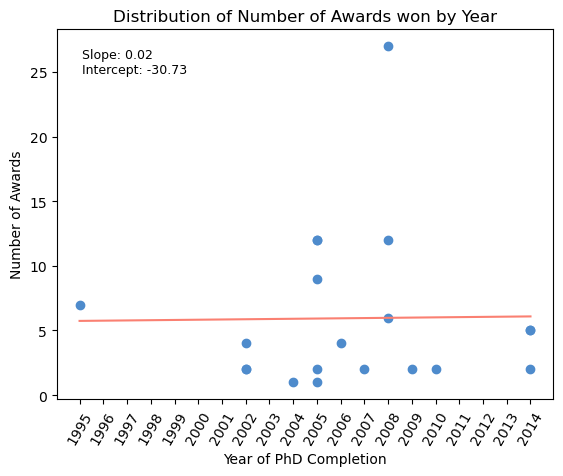

In [ ]:
'''Year of Phd completion vs Number of awards won'''

def linfunc(x,a,b):
    return a*x + b

def plotuh(x, y, xlabel, ylabel):
    plt.scatter(x, y, color='#4e8bcc')
    popt, pcov = curve_fit(linfunc, x, y)

    xdata = np.arange(int(min(x)), int(max(x)) + 1)
    plt.plot(xdata, linfunc(xdata, *popt), color='salmon')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=60)
    plt.xticks(xdata)  
    slope = round(popt[0], 2)
    intercept = round(popt[1], 2)
    plt.text(0.05, 0.95, f"Slope: {slope}\nIntercept: {intercept}", 
             transform=plt.gca().transAxes, fontsize=9, verticalalignment='top', color='black')
    plt.title("Distribution of Number of Awards won by Year")

    plt.show()


df_yrAw = df.dropna(subset=["Number_of_awards"])
years = df_yrAw["PhD_Year"]
Aws = df_yrAw["Number_of_awards"]

plotuh(years, Aws, "Year of PhD Completion", "Number of Awards")
    

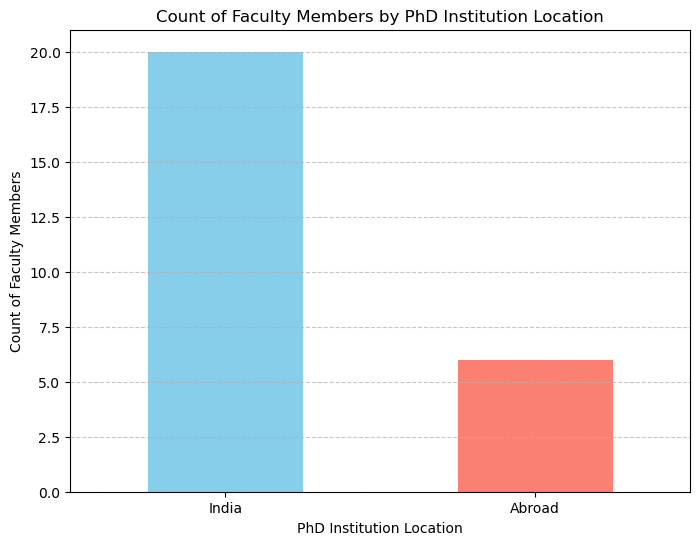

In [ ]:
'''Location of PhD vs Number of faculty'''

phd_counts = df['PhD_Institution'].value_counts()
plt.figure(figsize=(8, 6))
phd_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel("PhD Institution Location")

plt.ylabel("Count of Faculty Members")
plt.title("Count of Faculty Members by PhD Institution Location")
plt.xticks(rotation=0)  
plt.show()

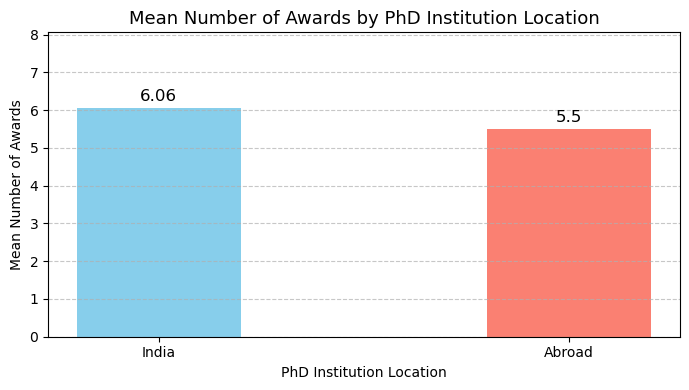

In [ ]:
'''Loaction of PhD Vs Mean number of awards won'''

df_filtered = df[df['PhD_Institution'].notna()]

mean_awards = df_filtered.groupby('PhD_Institution')['Number_of_awards'].mean()

mean_awards_india = mean_awards.get('India', 0)  
mean_awards_abroad = mean_awards.get('Abroad', 0)  

labels = ['India', 'Abroad']
mean_values = [mean_awards_india, mean_awards_abroad]

plt.figure(figsize=(7, 4))

bars = plt.bar(labels, mean_values, color=['skyblue', 'salmon'], width=0.4)

plt.title('Mean Number of Awards by PhD Institution Location', fontsize=13)
plt.xlabel('PhD Institution Location', fontsize=10)
plt.ylabel('Mean Number of Awards', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0, max(mean_values) + 2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

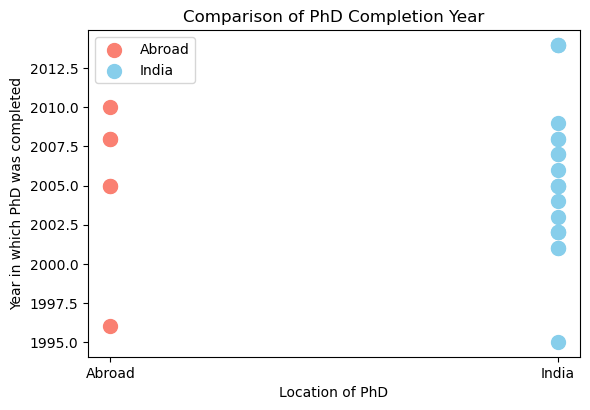

In [ ]:
'''Distribution of PhD completion year and location'''

df_filtered = df[df['PhD_Institution'].notna()]

abroad_mask = df_filtered['PhD_Institution'] == 'Abroad'

plt.figure(figsize=(6, 4))

plt.scatter(df_filtered[abroad_mask]['PhD_Institution'], df_filtered[abroad_mask]['PhD_Year'], 
            s=100, color='salmon', label='Abroad')

plt.scatter(df_filtered[~abroad_mask]['PhD_Institution'], df_filtered[~abroad_mask]['PhD_Year'], 
            s=100, color='skyblue', label='India')

plt.xlabel('Location of PhD')
plt.ylabel('Year in which PhD was completed')
plt.tight_layout()
plt.title("Comparison of PhD Completion Year")
plt.legend()

plt.show()